## Import Libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
%matplotlib inline

## Data Pre-Processing

In [4]:
# Load and combine data
PATH_TO_FILE_1 = "../raw data/aapl_2016_2020.csv"
PATH_TO_FILE_2 = "../raw data/aapl_2021_2023.csv"
half_1 = pd.read_csv(PATH_TO_FILE_1, low_memory=False)
half_2 = pd.read_csv(PATH_TO_FILE_2, low_memory=False)
df = pd.concat([half_1, half_2], ignore_index=True)
df.columns = df.columns.str.strip()

# Option type
option_type = "put"

# Convert Unix timestamps to datetime
df['QUOTE_DATETIME'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

# Load underlying price data for volatility computation
underlying_prices = df[['QUOTE_DATETIME', '[UNDERLYING_LAST]']].drop_duplicates().set_index('QUOTE_DATETIME').sort_index()

# Historical volatility calculation
def historical_volatility(series, window=20):
    return np.sqrt(252) * series.pct_change().rolling(window=window).std()

underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
underlying_prices.dropna(inplace=True)

# Merge historical volatility into main df
df = df.merge(underlying_prices[['hist_vol_20d']], left_on='QUOTE_DATETIME', right_index=True, how='inner')

# Select numeric columns based on option type
numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing essential data
df.dropna(subset=numeric_cols + ['hist_vol_20d'], inplace=True)

# Prepare dataset explicitly with bid and ask prices
option_df = df[['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d',
                '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']].copy()

option_df.columns = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                     'delta', 'gamma', 'vega', 'theta', 'rho', 'bid_price', 'ask_price']

# Normalize strike price and compute time to expiry in years
option_df['strike_price'] /= 1000
option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
option_df.drop('days_to_expiry', axis=1, inplace=True)

## MLP2 Model

In [5]:
# Prepare data for modeling with bid and ask
X = option_df[['underlying_price', 'strike_price', 'hist_volatility', 'delta', 'gamma', 'vega', 'theta', 'rho', 'time_to_expiry']]
y_bid_ask = option_df[['bid_price', 'ask_price']]

# Train-test split for bid/ask predictions
X_train, X_test, y_train_bid_ask, y_test_bid_ask = train_test_split(X, y_bid_ask, test_size=0.2, random_state=42)

def create_mlp2_model(input_dim):
    model = Sequential()
    
    model.add(Dense(400, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())

    model.add(Dense(400))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())

    model.add(Dense(400))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())

    model.add(Dense(2, activation='relu'))  # Bid and ask prediction outputs

    return model

## Model Training

In [8]:
input_dim = X_train.shape[1]
mlp2_model = create_mlp2_model(input_dim)

batch_size = 4096
optimizer = Adam(learning_rate=1e-3)

mlp2_model.compile(loss='mean_squared_error', optimizer=optimizer)

# Initial Training
history = mlp2_model.fit(X_train, y_train_bid_ask, epochs=30, batch_size=batch_size, validation_split=0.01)

# Learning Rate Scheduling
learning_rates = [1e-4, 1e-5, 1e-6]
epochs_lr = [10, 10, 10]

for lr, epochs in zip(learning_rates, epochs_lr):
    mlp2_model.optimizer.learning_rate.assign(lr)
    history = mlp2_model.fit(
        X_train, y_train_bid_ask, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_split=0.01
    )


mse_test = mlp2_model.evaluate(X_test, y_test_bid_ask, batch_size=batch_size)
print(f'Test MSE: {mse_test}')

Epoch 1/30


c:\GitHub Repos\CS-4641-Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\GitHub Repos\CS-4641-Project\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - loss: 775.6041 - val_loss: 1550.4806
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 28.9608 - val_loss: 1626.2690
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 27.6825 - val_loss: 1621.3710
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 38.0967 - val_loss: 1680.5869
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 40.1914 - val_loss: 1619.3828
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 15.3662 - val_loss: 1554.8347
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 22.4498 - val_loss: 1714.7142
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 11.2325 - val_loss: 1517.6343
Epoch 9/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 20.3348 - val_loss: 1669.6718
Epoch 10/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 25.1831 - val_loss: 1547.0784
Epoch 11/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 13.3290 - val_loss: 1735.2

## Loss


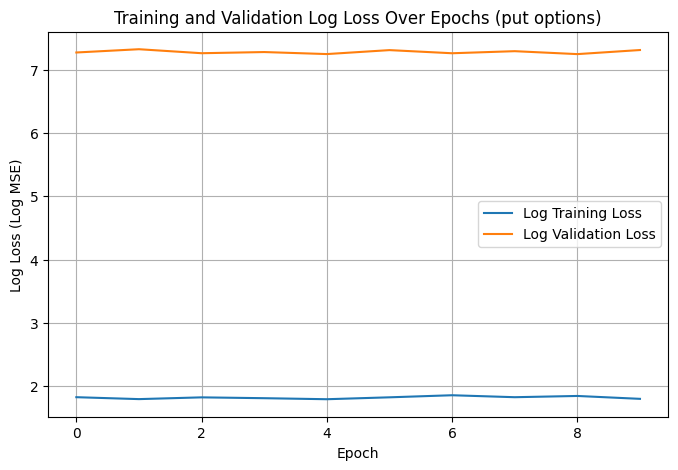

: 

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8,5))

eps = 1e-10  # tiny number to avoid log(0)
all_train_loss = history.history['loss']
all_val_loss = history.history['val_loss']
plt.plot(np.log(np.array(history.history['loss']) + eps), label='Log Training Loss')
plt.plot(np.log(np.array(history.history['val_loss']) + eps), label='Log Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Log Loss (Log MSE)')
plt.title(f'Training and Validation Log Loss Over Epochs ({option_type} options)')
plt.legend()
plt.grid(True)
plt.show()

## Save Model

In [ ]:
mlp2_model.save('mlp2_bid_ask_model.h5')